<p align="center"><img src="../../docs/spooky_logo.png" alt="spooky logo" width="400"/></p>

[![Documentation Status](https://readthedocs.org/projects/spookyspec/badge/?version=latest)](https://spookyspec.readthedocs.io/en/latest/?badge=latest)
[![PyPI version](https://badge.fury.io/py/spookyspec.svg)](https://badge.fury.io/py/spookyspec)

# spookyspec

### So simple it's scary

A python package to plot, analyze, and manipulate one-dimensional spectra.

See our [documentation](https://spookyspec.readthedocs.io/en/latest/)

#### Installation:

`pip install spookyspec`

### Example: Simulate HST/COS

The following spectra were produced as part of an HST/COS proposal to observe a polluted DA white dwarf with $T_{eff} = $ 48000 K

We will simulate spectra and use `spookyspec` to add noise and visualize it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
from scipy.interpolate import interp1d
from matplotlib import cm
np.seterr(divide='ignore', invalid='ignore')

import spookyspec as sp

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

#### Load Data

The following spectra were produced with stellar atmosphere codes TLUSTY and SYNSPEC.

I read them in and store as a Spec object

The three models represent three different accretion scenarios: comet halley abundances, bulk earth abundances, and predicted background abundances from radiative levitation

In [4]:
halley = sp.Spec(*sp.fits_to_np('wd_48000_787_CHsim_1050_gauss.fits'),
             stype = 'model',hdr=fits.getheader('wd_48000_787_CHsim_1050_gauss.fits'))
earth = sp.Spec(*sp.fits_to_np('wd_48000_787_BEsim_1050_gauss.fits'),
             stype = 'model',hdr=fits.getheader('wd_48000_787_BEsim_1050_gauss.fits'))
rad_lev = sp.Spec(*sp.fits_to_np('wd_48000_787_RLsim_1050_gauss.fits'),
             stype = 'model',hdr=fits.getheader('wd_48000_787_RLsim_1050_gauss.fits'))


Read in the COS G130M throughput function

In [5]:
df = pd.read_csv('G130M_1222_throughput.csv')
df = pd.concat([df,pd.DataFrame(columns=df.columns,data = [[1212.0000,0,0,0,0,0],[1221.9000,0,0,0,0,0]])])
df = df.sort_values('wavelength').reset_index(drop=True)

Simulating the COS spectum is easy using specplot. Lets do it for our model of an accreting gas giant planet will heavy element ratios similar to comet Halley.

We want to detect the N lines around 1090 angstroms. According to the ETC we can get SNR=19 with 5 orbits.

(1070.0, 1360.0)

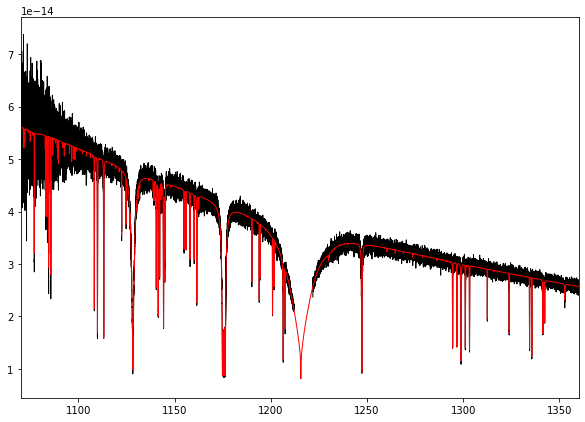

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(*halley.set_snr(1090,19,thrux=df['wavelength'],thruy=df['target_counts'],snr_max=45).show(),
        lw=1,c='k',label='Simulated COS')
ax.plot(*halley.show(),
        lw=1,c='r',label='Model')
ax.set_xlim(1070,1360)

In the above figure we can see some of the effects of interpolating the throughput in our simulation. For example, the regions blue of 1100 angstroms have relatively low throughput. There is also a gap in coverage around Ly$\alpha$, which we see.

#### Figure for HST proposal


The following figure was included in an HST/COS proposal. Bandpass and SNR info was calculated useing the HST/COS ETC

In [8]:
def line_label(ax,lam,el,height=0.9,offset=0.0):
    y0,y1 = ax.get_ylim()
    y = y0 + (y1-y0)*height
    ax.text(lam+offset,y,el,ha='center',fontsize=16,fontfamily='serif')
    ax.axvline(lam,0.83,0.87,c='k',lw=1)

Text(0.08, 0.4, '$F_{\\lambda}$ (10$^{-14}$ erg s$^{-1}$ cm$^{-2}$ $\\AA ^{-1}$)')

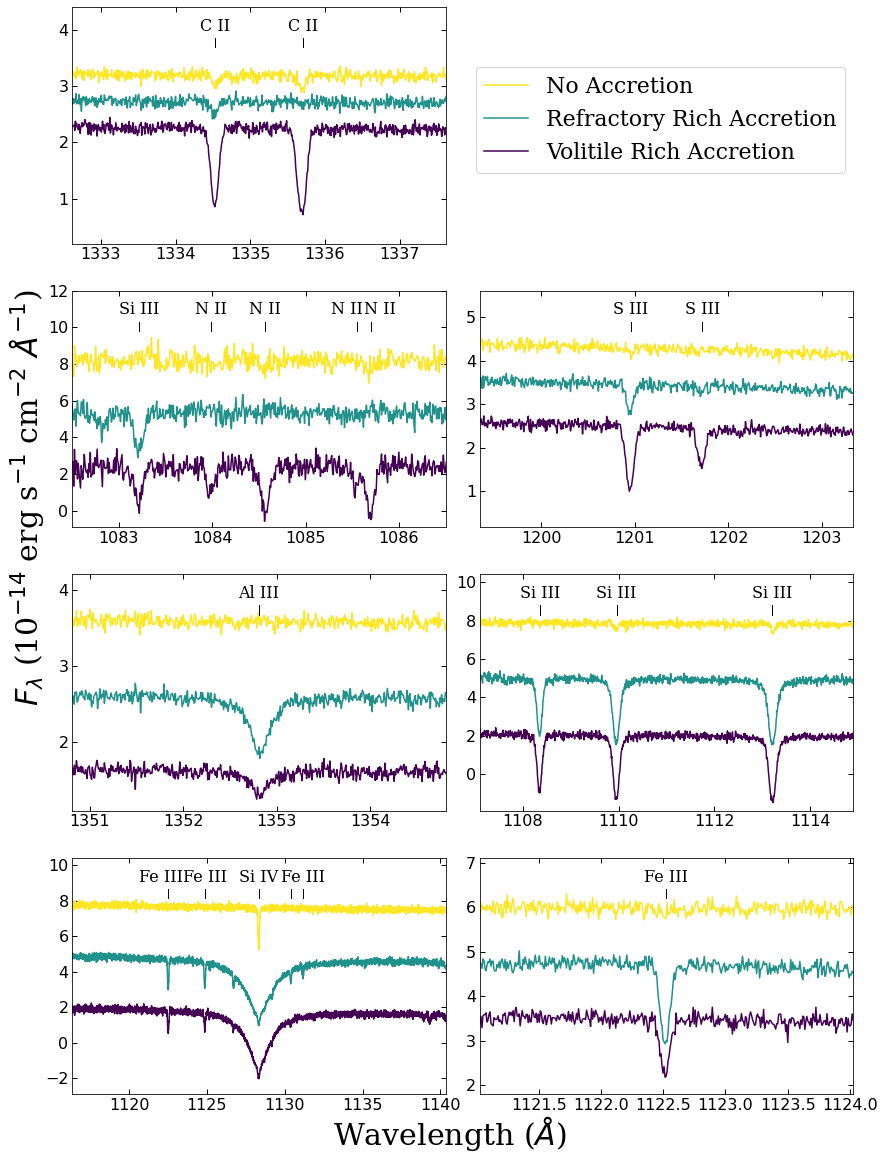

In [10]:
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
simCOS = plt.figure(figsize = (14,20))
gs = simCOS.add_gridspec(4, 4)
alii = simCOS.add_subplot(gs[2, :2])
ciii = simCOS.add_subplot(gs[0, :2])
feii = simCOS.add_subplot(gs[3, 2:])
nii = simCOS.add_subplot(gs[1, :2])
sii = simCOS.add_subplot(gs[1, 2:])
siiii = simCOS.add_subplot(gs[2, 2:])
siiv = simCOS.add_subplot(gs[3, :2])

viridis = cm.get_cmap('viridis', 3)

alii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-1e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# alii.plot(*e9.fnu().show(),c='xkcd:azure',label='Comet Halley Model')
alii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(0).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
alii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(1e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=1352.810
dw=2
alii.set_xlim(w-dw,w+dw)
alii.set_ylim(1.1,4.2)
# alii.legend(loc=(1.1,0.3),prop={'size':16,'family':'serif'})
line_label(alii,w,'Al III')
alii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
alii.set_xticks([1351,1352,1353,1354])
alii.set_yticks([2,3,4])
alii.yaxis.offsetText.set_fontsize(16)


# ciii.plot(*e9.fnu().show(),c='xkcd:azure',label='Comet Halley Model')

ciii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(0.5e-14).scale(1e14).show(),c=viridis(2),label='No Accretion')
ciii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).scale(1e14).show(),c=viridis(1),label='Refractory Rich Accretion')
ciii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-0.5e-14).scale(1e14).show(),c=viridis(0),label='Volitile Rich Accretion')
w=(1334.523+1335.708)*0.5
dw=2.5
ciii.set_xlim(w-dw,w+dw)
ciii.set_ylim(0.2,4.4)
ciii.legend(loc=(1.08,0.3),prop={'size':22,'family':'serif'})
line_label(ciii,1334.523,'C II')
line_label(ciii,1335.708,'C II')
ciii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
ciii.yaxis.offsetText.set_fontsize(16)

feii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-1.3e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# feii.plot(*e9.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).show(),c='xkcd:azure',label='Comet Halley Model')
feii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
feii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(1.3e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=1122.526
dw=1.5
feii.set_xlim(w-dw,w+dw)
feii.set_ylim(1.8,7.1)
line_label(feii,w,'Fe III')
feii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
feii.yaxis.offsetText.set_fontsize(16)

nii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-3e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# nii.plot(*e9.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).show(),c='xkcd:azure',label='Comet Halley Model')
nii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(0e-14).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
nii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(3e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=1084.5
dw=2
nii.set_xlim(w-dw,w+dw)
nii.set_ylim(-0.9,12)
# line_label(nii,1082.838,'Fe III',offset=-0.05)
line_label(nii,1083.216,'Si III')
line_label(nii,1083.990,'N II')
line_label(nii,1084.570,'N II')
line_label(nii,1085.546,'N II',offset=-0.1)
line_label(nii,1085.700,'N II',offset=0.1)
nii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
nii.set_xticks([1083,1084,1085,1086])
nii.yaxis.offsetText.set_fontsize(16)

sii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-1e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# sii.plot(*e9.fnu().show(),c='xkcd:azure',label='Comet Halley Model')
sii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
sii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(1e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=(1200.956+1201.722)*0.5
dw=2
sii.set_xlim(w-dw,w+dw)
sii.set_ylim(0.18,5.6)
line_label(sii,1200.956,'S III')
line_label(sii,1201.722,'S III')
sii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
sii.set_xticks([1200,1201,1202,1203])
sii.yaxis.offsetText.set_fontsize(16)

siiii.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-3e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# siiii.plot(*e9.fnu().show(),c='xkcd:azure',label='Comet Halley Model')
siiii.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(0e-14).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
siiii.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(3e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=1111
dw=3.9
siiii.set_xlim(w-dw,w+dw)
siiii.set_ylim(-1.9,10.4)
line_label(siiii,1113.204,'Si III')
line_label(siiii,1109.960,'Si III')
line_label(siiii,1108.358,'Si III')
siiii.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
siiii.yaxis.offsetText.set_fontsize(16)

siiv.plot(*halley.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(-3e-14).scale(1e14).show(),c=viridis(0),label='Simulated Comet Halley Abundances')
# siiv.plot(*e9.fnu().show(),c='xkcd:azure',label='Comet Halley Model')
siiv.plot(*earth.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(0e-14).scale(1e14).show(),c=viridis(1),label='Bulk Earth Model')
siiv.plot(*rad_lev.set_snr(1090,19,thrux = df['wavelength'],thruy = df['target_counts'],snr_max=45).yoffset(3e-14).scale(1e14).show(),c=viridis(2),label='Radiative Levitation Model')
w=1128.340
dw=12
siiv.set_xlim(w-dw,w+dw)
siiv.set_ylim(-2.9,10.4)
line_label(siiv,1122.524,'Fe III',offset=-0.5)
line_label(siiv,1124.874,'Fe III')
line_label(siiv,1128.340,'Si IV')
line_label(siiv,1130.395,'Fe III',offset=0.8)
line_label(siiv,1131.198,'')
siiv.tick_params(which='major', length=5, width=1, direction='in',labelsize=16)
siiv.yaxis.offsetText.set_fontsize(16)
simCOS.text(0.5,0.09,'Wavelength ($\AA$)',fontsize=30,fontfamily='serif',ha='center')
simCOS.text(0.08,0.4,r'$F_{\lambda}$ (10$^{-14}$ erg s$^{-1}$ cm$^{-2}$ $\AA ^{-1}$)',fontsize=30,fontfamily='serif',ha='center',rotation=90)